# Variational Quantum Eigensolver - Ground State Energy for $H2$ Molecule using the A ansatz

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ, QuantumRegister, ClassicalRegister

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

from qiskit.circuit import Parameter

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 f

In [3]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

In [4]:
class VariationalForms:

	def R(self, theta: float, phi: float):# -> Instruction:
		# num of num_qubits
		num_qubits: int = 1

		# quantum circuit
		qr: QuantumRegister = QuantumRegister(num_qubits)
		rgate: QuantumCircuit = QuantumCircuit(qr, name="$R(\\theta, \phi)$")
		
		# setup the gate
		rgate.ry( (0.5 * np.pi) + theta, qr[0])
		rgate.rz( np.pi + phi, qr[0])
		return rgate.to_instruction()

	
	def Rd(self, theta: float, phi: float):# -> Instruction:
		# num of num_qubits
		num_qubits = 1
		
		# quantum circuit
		qr = QuantumRegister(num_qubits)
		rdgate = QuantumCircuit(qr, name="$R(\\theta, \phi)^\dagger$")
		
		# setup the gate
		rdgate.rz( np.pi + phi, qr[0]).inverse()
		rdgate.ry( (0.5 * np.pi) + theta, qr[0]).inverse()
		return rdgate.to_instruction()

	
	def A(self, theta: float, phi: float):# -> Instruction:
		# num of num_qubits
		num_qubits = 2
		
		# quantum circuit
		qr = QuantumRegister(num_qubits)
		agate = QuantumCircuit(qr, name="$A(\\theta, \phi)$")
		
		# Rotation gates
		RGate = self.R(theta, phi)
		RDGate = self.Rd(theta, phi)
		# RGate = r.to_instruction()
		# RDGate = rd.to_instruction()
		
		# Gate setup
		agate.cx(1, 0)
		agate.append(RDGate, [qr[1]])
		agate.cx(0, 1)
		agate.append(RGate, [qr[1]])
		agate.cx(1, 0)
		return agate.to_instruction()


	def draw(self, g, theme: str = "mpl", decomposed: bool = False):
		num_qubits: int = g.num_qubits
		qc = QuantumCircuit(num_qubits)
		qc.append( g, list(np.arange(num_qubits)) )
		if decomposed:
			return qc.decompose().draw(theme)
		return qc.draw("mpl", initial_state=True)

	def decompose(self, g, theme: str = "mpl"):
		num_qubits: int = g.num_qubits
		qc = QuantumCircuit(num_qubits)
		qc.append( g, list(np.arange(num_qubits)) )
		return qc.decompose().draw(theme, initial_state=True)

In [5]:
vf = VariationalForms()

Backend

In [6]:
qasm_sim = QasmSimulator()
state_sim = StatevectorSimulator()

Drivers

Below we set up a PySCF driver for $H2$ molecule at equilibrium bond length 0.735 Angstrom

In [7]:
def exact_diagonalizer(es_problem, qubit_converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(qubit_converter, solver)
    result = calc.solve(es_problem)
    return result

In [8]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [9]:
def initial_state_preparation(dist: float, mapper_str: str = "jw"):
    
    molecule = "H 0.0 0.0 0.0; H 0.0 0.0 " + str(dist)
    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)#, z2symmetry_reduction=[1, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [10]:
inter_atomic_dists: list = np.arange(0.45, 1.25, 0.05)

In [11]:
numpy_eigensolver_electronic_ground_energies: list = []
numpy_eigensolver_nuclear_repulsion_energies: list = []
numpy_eigensolver_total_ground_state_energies: list = []

from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

print("Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")
    # construct NumPyEigensolver - solver algorithm
    numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
    # calculate excited states using the NumPyEigensolver solver algorithm
    numpy_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, numpy_solver)
    # Compute Ground and Excited States properties.
    numpy_ground_excited_states_properties = numpy_excited_states_calculation.solve(es_problem)
    
    # Get Repulsion energy from properties of ground and excited states
    nuclear_repulsion_energy = numpy_ground_excited_states_properties.nuclear_repulsion_energy
    numpy_eigensolver_nuclear_repulsion_energies.append(nuclear_repulsion_energy)
    
    # constructs NumPyMinimumEigensolver - solver algorithm
    numpy_minimum_solver = NumPyMinimumEigensolverFactory()
    # compute the ground state using a minimum eigensolver
    numpy_ground_state_calculation = GroundStateEigensolver(qubit_converter, numpy_minimum_solver)
    # Compute Ground state properties - returns an Eigenstate result
    numpy_ground_state_properties = numpy_ground_state_calculation.solve(es_problem)
    
    # Get electronic ground state energies
    electronic_ground_energy = np.real(numpy_ground_state_properties.eigenenergies[0])
    numpy_eigensolver_electronic_ground_energies.append(electronic_ground_energy)
    
    # Get the total ground state energy
    total_ground_state_energy = (electronic_ground_energy + nuclear_repulsion_energy)
    numpy_eigensolver_total_ground_state_energies.append(total_ground_state_energy)
    
    print("Interatomic dist: {:.4f} Å \t Electronic Ground Energy: {:.4f} Eh \tTotal Ground State Energy: {:.4f} Eh".format(dist, electronic_ground_energy, total_ground_state_energy))
    # print("Interatomic dist: {:.4f} Å \t Total Ground State Energy: {:.4f} Eh".format(dist, total_ground_state_energy))
    

Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm

Interatomic dist: 0.4500 Å 	 Electronic Ground Energy: -2.1744 Eh 	Total Ground State Energy: -0.9984 Eh
Interatomic dist: 0.5000 Å 	 Electronic Ground Energy: -2.1135 Eh 	Total Ground State Energy: -1.0552 Eh
Interatomic dist: 0.5500 Å 	 Electronic Ground Energy: -2.0548 Eh 	Total Ground State Energy: -1.0926 Eh
Interatomic dist: 0.6000 Å 	 Electronic Ground Energy: -1.9982 Eh 	Total Ground State Energy: -1.1163 Eh
Interatomic dist: 0.6500 Å 	 Electronic Ground Energy: -1.9440 Eh 	Total Ground State Energy: -1.1299 Eh
Interatomic dist: 0.7000 Å 	 Electronic Ground Energy: -1.8922 Eh 	Total Ground State Energy: -1.1362 Eh
Interatomic dist: 0.7500 Å 	 Electronic Ground Energy: -1.8427 Eh 	Total Ground State Energy: -1.1371 Eh
Interatomic dist: 0.8000 Å 	 Electronic Ground Energy: -1.7956 Eh 	Total Ground State Energy: -1.1341 Eh
Interatomic dist: 0.8500 Å 	 Electronic Ground Energy: -1.7509 Eh 	Total Gro

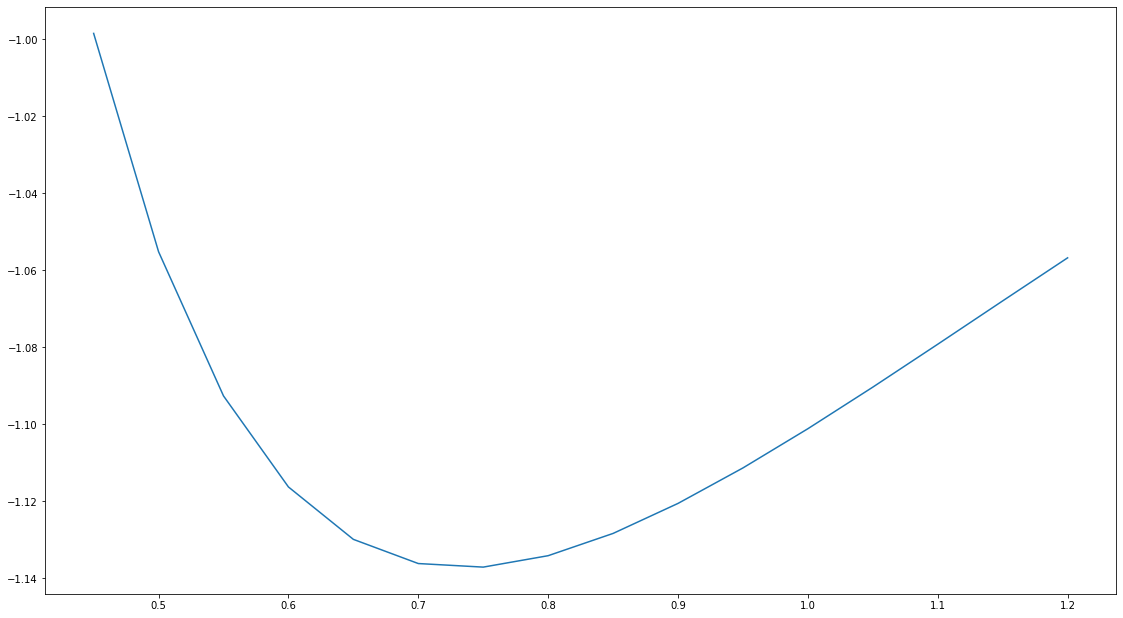

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies)
plt.show()

In [15]:
def ansatz_preparation():
    phi = Parameter('p')
    theta = Parameter('t')

    n = qubit_op.num_qubits

    qc = QuantumCircuit(n)

    # A = vf.A( theta, phi )
    # Rd = vf.Rd( theta, phi )
    # R = vf.R( theta, phi )

    qc.cx(1, 0)

    qc.rz(np.pi + phi, 1)
    qc.ry((0.5 * np.pi) + theta, 1)

    # qc.append(Rd, [1])

    qc.cx(0, 1)

    qc.ry((0.5 * np.pi) + theta, 1)
    qc.rz(np.pi + phi, 1)

    # qc.append®

    qc.cx(1, 0)

    # qc.draw("mpl")


    ansatz = qc
    
    return ansatz

In [24]:
a_electronic_ground_energies: list = []
a_nuclear_repulsion_energies: list = []
a_total_ground_state_energies: list = []

from qiskit.utils import QuantumInstance
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory, VQEUCCFactory

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

# provider = IBMQ.get_provider(hub='ibm-q')
# backend = provider.get_backend('ibmq_toronto')
backend = state_sim#Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend=backend)
optimizer = SLSQP(maxiter=5)
# optimizer = COBYLA(maxiter=10000)

print("Total Ground State Energies of H2 Molecule using UCCSD ansatz\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")

    init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

    # init_state.draw("mpl", initial_state=True)

    # Setting up TwoLocal for our ansatz
    ansatz_type = "A"

    ansatz = ansatz_preparation()
    
    # Add the initial state
    ansatz.compose(init_state, front=True, inplace=True)

    # try:
    #     initial_point = [0.01] * len(ansatz.ordered_parameters)
    # except:
    #     initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(
        ansatz,
        optimizer=optimizer,
        quantum_instance=state_sim,
        callback=callback,
        # initial_point=initial_point
    )

    result = algorithm.compute_minimum_eigenvalue(qubit_op)
    print(result)
    a_total_ground_state_energies.append( np.real(result.eigenvalue) )
    # print(np.real(result.eigenvalue))
    

{   'aux_operator_eigenvalues': None,
    'cost_function_evals': 3,
    'eigenstate': array([0.00000000e+00+0.00000000e+00j, 1.25875283e-17+0.00000000e+00j,
       1.00000000e+00+2.77555756e-17j, 0.00000000e+00+0.00000000e+00j]),
    'eigenvalue': (-0.6453294085902546+0j),
    'optimal_parameters': {   Parameter(t): 2.5734590734486407,
                              Parameter(p): 6.036818385118334},
    'optimal_point': array([6.03681839, 2.57345907]),
    'optimal_value': -0.6453294085902546,
    'optimizer_evals': None,
    'optimizer_time': 0.019798755645751953}


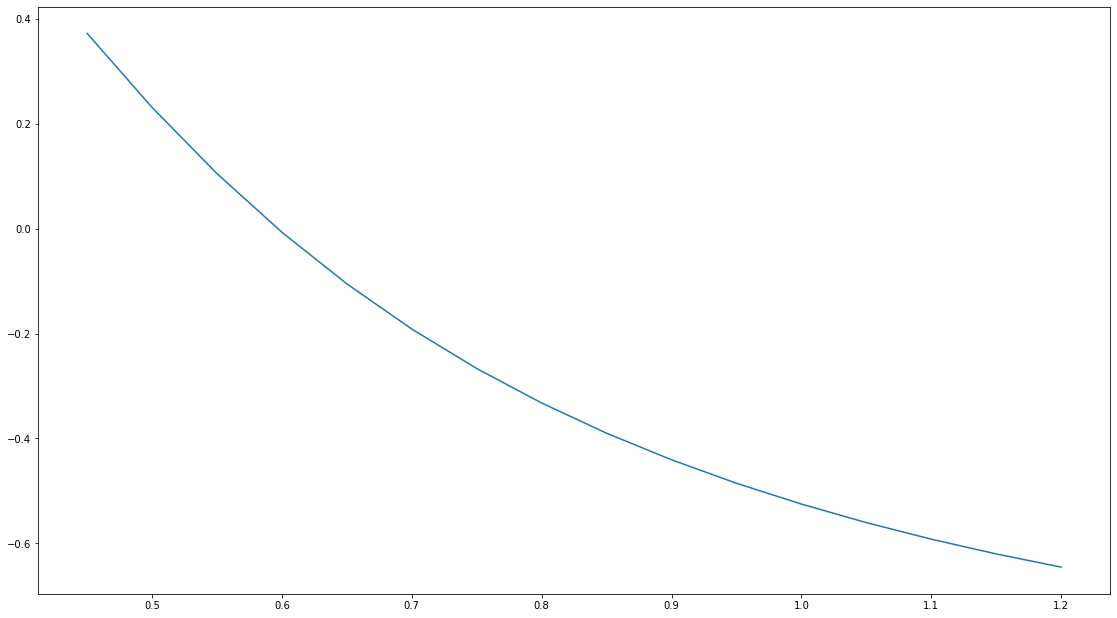

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
# plt.plot(inter_atomic_dists, numpy_minimum_solver_total_ground_state_energies)
plt.plot(inter_atomic_dists, a_total_ground_state_energies)
plt.show()

In [26]:
# Storing results in a dictionary
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Unroller
# Unroller transpile our circuit into CNOTs and U gates
pass_ = Unroller(['u', 'cx'])
pm = PassManager(pass_)
ansatz_tp = pm.run(ansatz)
cnots = ansatz_tp.count_ops()['cx']
score = cnots
accuracy_threshold = 4.0 # in mHa
energy = result.optimal_value

# if ansatz_type == "TwoLocal":
result_dict = {
    'optimizer': optimizer.__class__.__name__,
    'mapping': qubit_converter.mapper.__class__.__name__,
    'ansatz': ansatz.__class__.__name__,
    # 'rotation blocks': rotation_blocks,
    # 'entanglement_blocks': entanglement_blocks,
    # 'entanglement': entanglement,
    # 'repetitions': repetitions,
    # 'skip_final_rotation_layer': skip_final_rotation_layer,
    # 'energy (Ha)': energy,
    # 'error (mHa)': (energy-exact_energy)*1000,
    # 'pass': (energy-exact_energy)*1000 <= accuracy_threshold,
    '# of parameters': len(result.optimal_point),
    'final parameters': result.optimal_point,
    '# of evaluations': result.optimizer_evals,
    'optimizer time': result.optimizer_time,
    '# of qubits': int(qubit_op.num_qubits),
    '# of CNOTs': cnots,
    # 'score': score
}

,optimizer,ansatz,# of qubits,# of parameters
0,SLSQP,QuantumCircuit,2,2


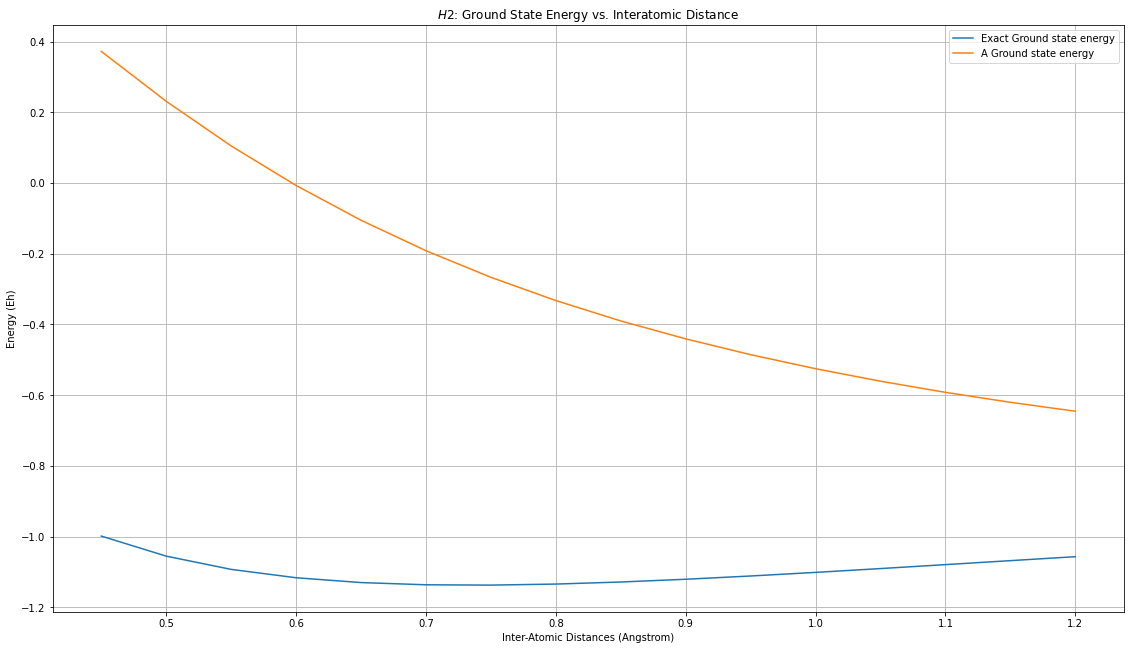

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))

plt.title(r"$H2$: Ground State Energy vs. Interatomic Distance")

ax.set_xlabel('Inter-Atomic Distances (Angstrom)')
ax.set_ylabel('Energy (Eh)')
ax.grid()

plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies, label="Exact Ground state energy")
plt.plot(inter_atomic_dists, a_total_ground_state_energies, label="A Ground state energy")

plt.legend()

# fig_title = f"{result_dict['optimizer']}-{result_dict['mapping']}-{result_dict['ansatz']}.png"
# fig.savefig(fig_title, dpi=300)


# Displaying and saving the data

import pandas as pd

result_df = pd.DataFrame.from_dict([result_dict])
result_df[['optimizer','ansatz', '# of qubits', '# of parameters']]

# plt.show()